## Objective

유저에게 아이템을 추천할 때 사용할 수 있는 데이터에는 나이, 성별 등의 **유저 정보**, 가격 / 색상 등의 **아이템 정보**, 거래/좋아요 등 유저와 아이템 사이의 **상호작용 정보**가 있습니다. 하지만 실무에서 유저와 아이템의 정확한 정보를 풍부하게 확보하는 것은 쉬운 일이 아닙니다. 이러한 문제를 극복하고자 연구하고 개발된 것이 유저와 아이템 사이의 상호작용 데이터를 이용해 유저간 혹은 아이템 간의 유사도를 계산하여 추천하는 협업 필터링(Collaborative Filtering)입니다

## Collaborative Filtering 이란?

![](https://upload.wikimedia.org/wikipedia/commons/5/52/Collaborative_filtering.gif)

Collaborative Filtering은 유저가 아이템에 행한 선호 / 구매 / 페이지 뷰에 대한 **상호작용 정보**를 바탕으로 유사한(similar) 아이템을 선정해 추천하는 알고리즘을 의미합니다. 

CF(Collaborative Filtering)에는 다양한 방법론이 존재합니다. 크게 2가지로 나눌 수 있는데, 
어떠한 **학습 과정 없이** 데이터 내 유사도를 직접 구해서 추천하는 Memory-Based CF와 데이터를 통해 유저와 아이템의 잠재 변수를 추론해내 유사도를 구하는 방식의 Model-Based CF가 있습니다. 

주요 알고리즘들을 다루기 전에, 우선 데이터부터 살펴보도록 하겠습니다.

## 다룰 데이터 : LastFM


로그 데이터에는 고객이 직접 선호를 드러내지는 않았지만 소비 활동에서 자연스럽게 기록된 "페이지 뷰 로그","장바구니 담기 기록", "구매" 등이 있습니다. 추천시스템에서 자주 쓰이는 MovieLens는 고객이 직접 특정 제품에 **별점**을 부여하는 방식으로 만들어진 데이터로, 그객이 직접 선호를 드러냅니다. 하지만 아래에서 다룰 <font color='red'>**Last.FM**</font>은 MovieLens와 달리 유저가 음악을 얼마나 실행했는지에 대한 정보만 들어 있습니다.

<img width="500" src="https://user-images.githubusercontent.com/66022630/84606513-ce493400-aee1-11ea-84b8-c868c7e330fa.png">

위의 데이터는 일정 기간 내 특정 유저(artist_id)가 특정 아티스트의 곡(artist_id)을 몇 번이나 실행시켰는지(plays)를 의미합니다. 이러한 정보를 보통 Implicit Data라 합니다. Movielens의 별점 데이터와 달리, 고객의 청취 데이터는 명료하게 선호를 드러내는 정보가 아니기 때문입니다. 청취를 얼마나 반복했는지보다, 어떤 음악가를 청취했고 어떤 음악가는 청취하지 않았는지에 대한 사실이 더 중요합니다. 

### 모듈 가져오기

In [3]:
%matplotlib inline

import pandas as pd
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt

### 데이터 가져오기 

[Music Recommendation datasets for Research](http://ocelma.net/MusicRecommendationDataset/)에서 1) 360k User로 이루어진 데이터셋을 다운 받은 후, 몇 가지 가공만 거친 데이터셋입니다. 

In [11]:
ROOT_URL = "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/data/"

# 데이터 가져오기
play_path = get_file("lastfm_play.csv", 
                     ROOT_URL+"lastfm_play.csv")
artist_path = get_file("lastfm_artist.csv", 
                       ROOT_URL+"lastfm_artist.csv")
user_path = get_file("lastfm_user.csv", 
                     ROOT_URL+"lastfm_user.csv")

play_df = pd.read_csv(play_path)
artist_df = pd.read_csv(artist_path)
user_df = pd.read_csv(user_path)

### 데이터 탐색하기

#### 문제정의와 부합하는 데이터 확인

먼저 상호작용 데이터를 살펴봅시다. `play_df`는 유저별 아티스트의 노래를 얼마나 재생했는지에 대한 데이터입니다. 각 칼럼의 의미는 아래와 같습니다.

* user_id : 유저(user) 식별자<br>
* artist_id  : 아티스트(item) 식별자<br>
* plays    : 각 유저의 아티스트 소비(재생) 횟수<br>

In [3]:
print("play_df의 크기 : ", play_df.shape)

# 5개를 Random으로 가져옴
play_df.sample(5, random_state=1)

play_df의 크기 :  (17302623, 3)


,user_id,artist_id,plays
7374310,153017,25808,123
457097,9475,62,20
13284433,275810,4217,52
6406613,133005,2632,45
2074779,43062,266,186


그리고 추가적으로 해당 유저의 신상 정보(`user_df`)와 아티스트의 이름(`artist_df`)은 다음과 같습니다. 

In [4]:
print("user dataframe")
display(user_df.head())

print("artist dataframe")
display(artist_df.head())

user dataframe


,user_id,gender,age,country
0,0,f,22,Germany
1,1,f,-1,Canada
2,2,None,-1,Germany
3,3,m,19,Mexico
4,4,m,28,United States


artist dataframe


,artist_id,artist_name
0,0,betty blowtorch
1,1,die Ärzte
2,2,melissa etheridge
3,3,elvenking
4,4,juliette & the licks


**(1) 유저 별 평균 몇 명의 아티스트 음악을 재생했는지 보기**

유저 별로 몇 명의 아티스트의 음악을 재생했는지 봅시다. 평균 50명 내외의 아티스트의 음악을 재생하는 것을 알 수 있습니다. 

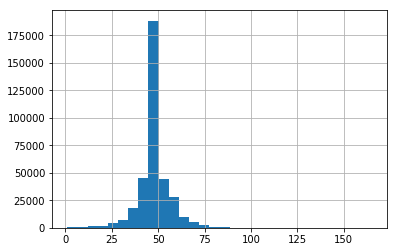

In [5]:
(
    play_df
    .groupby('user_id')
    ['artist_id']
    .count()
    .hist(bins=30)
)
plt.show()

**(2) 아티스트 별로 몇 명의 유저가 재생했는지 보기**

아티스트를 기준으로, 각 아티스트마다 몇 명의 유저가 음악을 들어줬는지 봅시다. 그래프가 왼쪽으로 치우친 형태입니다. 250명 이상의 유저가 들은 인기있는 아티스트 아티스트는 극히 일부인 것을 알 수 있습니다. 대부분의 아티스트는 50명 이내의 유저가 들은 기록을 가지고 있습니다. 대부분 아티스트들은 유저들의 선택을 받지 못하고 있는 상태입니다.

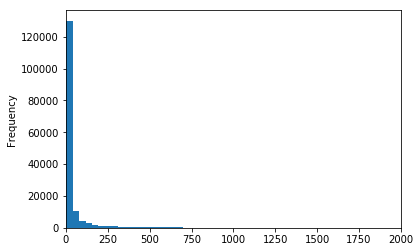

In [6]:
(
    play_df
    .groupby('artist_id')
    ['user_id']
    .count()
    .plot(kind='hist',bins=2000, xlim=(0,2000))
)
plt.show()

**(3) 유저 별로 아티스트의 음악을 평균 몇 번 재생했는지 보기**

이번에는 유저별로 각 아티스트의 음악을 몇 번이나 들었는지 알아보겠습니다. 평균 적으로 아티스트 별 213회 정도의 재생이 일어났는데, 중간 값은 이보다 작은 125회이고, 최대 재생 횟수는 6만 회가 넘습니다. 그래프가 왼쪽으로 치우쳐져 있다는 것을 이 차이를 통해서도 알 수 있습니다. 

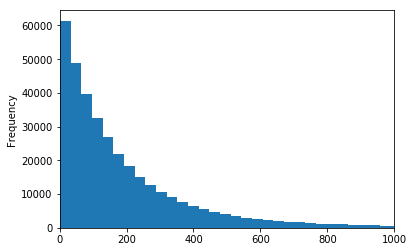

In [7]:
(
    play_df
    .groupby('user_id')
    ['plays']
    .mean()
    .plot(kind='hist',xlim=(0,1000),bins=2000)
)
plt.show()